Start

## Imports and Reload

In [96]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from features.feature_engineering import build_feature_pipeline
from sklearn.model_selection import train_test_split
from features.encoder import ManualWOEEncoder as WOEEncoderWrapper
from features.proxy_target_engineering import ProxyTargetEngineer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [97]:
# Load your data
df = pd.read_parquet('../../data/interim/clean_data.parquet')
df.sample(5)
df.columns

Index(['AccountId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'Amount', 'Value', 'TransactionStartTime',
       'PricingStrategy', 'FraudResult', 'transaction_hour', 'transaction_day',
       'transaction_month', 'transaction_weekday', 'is_large_transaction',
       'Amount_log', 'Amount_capped', 'is_outlier_Amount'],
      dtype='object')

## Train/Val Split

In [98]:
# Temporarily retain FraudResult as dummy y
X = df.copy()
y_dummy = df['FraudResult']

X_train, X_val, y_dummy_train, y_dummy_val = train_test_split(
    X,
    y_dummy,
    test_size=0.2,
    random_state=42
)


## Run Customer Aggregates

In [99]:
pipeline = build_feature_pipeline()
pipeline.fit(X_train, y_dummy_train)

agg = pipeline.named_steps["customer_agg"].transform(X_train)

try:
    agg_feature_names = pipeline.named_steps["customer_agg"].get_feature_names_out()
except AttributeError:
    agg_feature_names = [
        "total_transaction_amount",
        "avg_transaction_amount",
        "transaction_count",
        "std_transaction_amount"
    ]

agg_df = pd.DataFrame(
    data=agg,
    columns=agg_feature_names,
    index=X_train.index
)

X_train_augmented = X_train.join(agg_df)


## New ProxyTargetEngineer Code (without Monetary)

In [100]:
# Create ProxyTargetEngineer
engineer = ProxyTargetEngineer(snapshot_date='2023-12-31')

# Get the original RFM
rfm = engineer.calculate_rfm(
    df,
    customer_id_col='CustomerId',
    date_col='TransactionStartTime',
    amount_col='Amount'
)

# Keep only Frequency and Recency
rfm_simple = rfm[["CustomerId", "Frequency", "Recency"]]

# Scale features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_values = scaler.fit_transform(rfm_simple[["Frequency", "Recency"]])
rfm_scaled = pd.DataFrame(
    scaled_values,
    columns=["Frequency_scaled", "Recency_scaled"],
    index=rfm_simple.index
)
rfm_simple_scaled = pd.concat([rfm_simple[["CustomerId"]], rfm_scaled], axis=1)

# K-Means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

rfm_simple_scaled["Cluster"] = clusters


## Identify High-Risk Cluster

In [101]:
# Analyze clusters
cluster_summary = (
    rfm_simple_scaled.groupby("Cluster")[["Frequency_scaled", "Recency_scaled"]]
    .mean()
    .sort_values(["Frequency_scaled", "Recency_scaled"])
)
print(cluster_summary)

# Define high-risk cluster as the cluster with:
# - lowest frequency
# - highest recency
high_risk_cluster = cluster_summary.index[0]
print("High risk cluster:", high_risk_cluster)

# Assign high-risk label
rfm_simple_scaled["is_high_risk"] = (rfm_simple_scaled["Cluster"] == high_risk_cluster).astype(int)

# Prepare labels for merge
high_risk_labels = rfm_simple_scaled[["CustomerId", "is_high_risk"]]


         Frequency_scaled  Recency_scaled
Cluster                                  
2               -0.192189        1.544368
0               -0.163627        0.309778
1                0.186365       -0.867592
High risk cluster: 2


## Merge Label into X_train_augmented

In [102]:
# Merge new proxy label
X_train_augmented = X_train_augmented.merge(
    high_risk_labels,
    on='CustomerId',
    how='left'
)

# Fill missing labels
X_train_augmented["is_high_risk"] = X_train_augmented["is_high_risk"].fillna(0).astype(int)


In [103]:
print(X_train_augmented.columns)


Index(['AccountId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'Amount', 'Value', 'TransactionStartTime',
       'PricingStrategy', 'FraudResult', 'transaction_hour', 'transaction_day',
       'transaction_month', 'transaction_weekday', 'is_large_transaction',
       'Amount_log', 'Amount_capped', 'is_outlier_Amount',
       'total_transaction_amount', 'avg_transaction_amount',
       'std_transaction_amount', 'transaction_count', 'is_high_risk'],
      dtype='object')


## Now Set Proxy as Target

In [104]:
# Define new target
y_train = X_train_augmented["is_high_risk"]

In [105]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
print("Feature names shape:", len(feature_names))

ct = pipeline.named_steps["preprocessor"]
passthrough_cols = ct.transformers_[-1][2]
print("Passthrough columns:", passthrough_cols)
print("Count:", len(passthrough_cols))

passthrough_cols_existing = [c for c in passthrough_cols if c in X_train_augmented.columns]
print("Existing passthrough cols:", passthrough_cols_existing)


Feature names shape: 23
Passthrough columns: [0, 1, 10, 11, 12, 13, 14, 18]
Count: 8
Existing passthrough cols: []


In [106]:
# Fit preprocessor
pipeline.named_steps["preprocessor"].fit(X_train_augmented, y_train)

# Transform data
X_train_transformed = pipeline.named_steps["preprocessor"].transform(X_train_augmented)

feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

processed_data = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train_augmented.index
)

# Attach target
processed_data["is_high_risk"] = y_train.values


In [107]:
processed_data.head()

,datetime__TransactionStartTime_hour,datetime__TransactionStartTime_day,datetime__TransactionStartTime_month,datetime__TransactionStartTime_weekday,datetime__TransactionStartTime_year,numeric__Amount,numeric__Value,numeric__Amount_log,numeric__Amount_capped,numeric__total_transaction_amount,...,woe__ChannelId_woe,woe__ProviderId_woe,woe__ProductId_woe,onehot__PricingStrategy_0,onehot__PricingStrategy_1,onehot__PricingStrategy_2,onehot__PricingStrategy_4,onehot__is_large_transaction_0,onehot__is_large_transaction_1,is_high_risk
0,8.0,13.0,1.0,6.0,2019.0,-0.056453,-0.080693,-1.100214,-0.217245,0.324373,...,0.051903,0.04972,-0.036485,0.0,0.0,1.0,0.0,1.0,0.0,0
1,16.0,21.0,12.0,4.0,2018.0,-0.015089,-0.040890,0.721107,0.201962,0.144422,...,0.003897,0.16135,0.291564,0.0,0.0,1.0,0.0,1.0,0.0,0
2,18.0,23.0,1.0,2.0,2019.0,-0.047531,-0.073382,-0.029698,-0.126828,0.145476,...,0.003897,0.16135,0.139829,0.0,0.0,1.0,0.0,1.0,0.0,0
3,11.0,12.0,1.0,5.0,2019.0,-0.056209,-0.080937,-1.264710,-0.214779,1.908076,...,0.051903,0.04972,-0.036485,0.0,0.0,1.0,0.0,1.0,0.0,0
4,7.0,8.0,2.0,4.0,2019.0,0.106567,0.080956,1.368067,1.434925,0.153514,...,0.003897,0.16135,0.291564,0.0,0.0,1.0,0.0,0.0,1.0,0


## Check Correlation

In [108]:
processed_data["FraudResult"] = df.loc[X_train_augmented.index, "FraudResult"].values

correlation = processed_data[["is_high_risk", "FraudResult"]].corr().loc["is_high_risk", "FraudResult"]
print(f"Correlation between is_high_risk and FraudResult: {correlation:.4f}")

Correlation between is_high_risk and FraudResult: 0.0049


In [109]:
print("Distribution of is_high_risk:")
print(processed_data['is_high_risk'].value_counts(normalize=True))

Distribution of is_high_risk:
is_high_risk
0    0.941787
1    0.058213
Name: proportion, dtype: float64


In [110]:
cross_tab = pd.crosstab(processed_data['is_high_risk'], processed_data['FraudResult'], margins=True)
print(cross_tab)

FraudResult       0    1    All
is_high_risk                   
0             71958  116  72074
1              4444   11   4455
All           76402  127  76529


In [111]:
correlation = processed_data[['is_high_risk', 'FraudResult']].corr().loc['is_high_risk', 'FraudResult']
print(f"Correlation between is_high_risk and FraudResult: {correlation:.4f}")

Correlation between is_high_risk and FraudResult: 0.0049


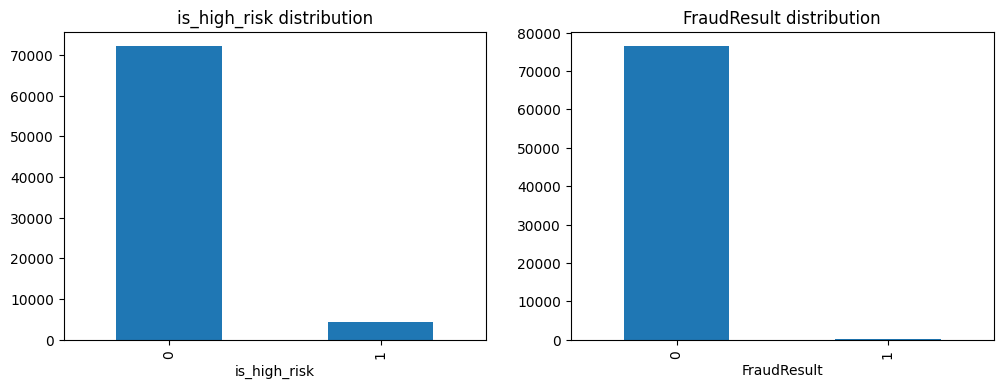

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))
processed_data['is_high_risk'].value_counts().plot(kind='bar', ax=ax[0], title='is_high_risk distribution')
processed_data['FraudResult'].value_counts().plot(kind='bar', ax=ax[1], title='FraudResult distribution')
plt.show()

In [113]:
rfm = engineer.calculate_rfm(
    df,
    customer_id_col="CustomerId",
    date_col="TransactionStartTime",
    amount_col="Amount"
)

rfm = rfm.merge(df.groupby("CustomerId")["FraudResult"].max().reset_index(), on="CustomerId", how="left")

print(rfm.groupby("FraudResult").mean(numeric_only=True)
)


                 Monetary  Frequency      Recency
FraudResult                                      
0            6.137164e+04  24.970445  1812.179230
1            7.709334e+06  66.129630  1808.574074


In [115]:
processed_data.columns

Index(['datetime__TransactionStartTime_hour',
       'datetime__TransactionStartTime_day',
       'datetime__TransactionStartTime_month',
       'datetime__TransactionStartTime_weekday',
       'datetime__TransactionStartTime_year', 'numeric__Amount',
       'numeric__Value', 'numeric__Amount_log', 'numeric__Amount_capped',
       'numeric__total_transaction_amount', 'numeric__avg_transaction_amount',
       'numeric__transaction_count', 'numeric__std_transaction_amount',
       'woe__ProductCategory_woe', 'woe__ChannelId_woe', 'woe__ProviderId_woe',
       'woe__ProductId_woe', 'onehot__PricingStrategy_0',
       'onehot__PricingStrategy_1', 'onehot__PricingStrategy_2',
       'onehot__PricingStrategy_4', 'onehot__is_large_transaction_0',
       'onehot__is_large_transaction_1', 'is_high_risk', 'FraudResult'],
      dtype='object')

In [114]:
processed_data.to_parquet('../../data/processed/processed_data.parquet')